# 1.0 Present wrong code from ChatGPT

```Python
# Wrong code (Fix!)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data for 2 assets
asset1 = pd.read_csv('asset1.csv', index_col=0)
asset2 = pd.read_csv('asset2.csv', index_col=0)

# Compute z-scores for each asset
z1 = (asset1 - asset1.mean()) / asset1.std()
z2 = (asset2 - asset2.mean()) / asset2.std()

# Compute the spread between the two assets
z_spread = z1 - z2

# Compute the rolling mean and standard deviation of the spread
spread_mean = z_spread.rolling(30).mean()
spread_std = z_spread.rolling(30).std()

# Compute the upper and lower bounds fot the spread
upper_bound = spread_mean + spread_std * 2
lower_bound = spread_mean - spread_std * 2

# Compute long and short signals
long_signals = (z_spread <= lower_bound)
short_signals = (z_spread >= upper_bound)

# Compute the positions for each asset
asset_1_position = -long_signals + short_signals
asset_2_position = long_signals - short_signals

# Compute the portfloio returns
portfolio_returns = asset_1_position.shift(1) * z1 + asset_2_position.shift(1) * z2

# Compute the total returns
total_returns = portfolio_returns.sum(axis=1)

# Plot the results
plt.plot(total_returns.cumsum())
plt.title('Total returns from pairs trading')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()
```

# 2.0 Fix the code

## 2.0. imports

In [1]:
# Wrong code (Fix!)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

## 2.1. Load fake data

In [2]:
# Load data for 2 assets

# Let's create a method for creating assets fake data
def create_assets_data():
    """create the two assets as dataframes"""
    
    # create a list of feasible percentual random stock returns
    percentual_rets = np.random.normal(0, 0.005, (1000, 2))
    
    
    # calculate asset1 prices starting with a value of 100
    assets_1_prices = 100 * np.cumprod(1 + percentual_rets[:, 0])
    assets_2_prices = 100 * np.cumprod(1 + percentual_rets[:, 1])
    
    return pd.DataFrame(assets_1_prices), pd.DataFrame(assets_2_prices)

asset1, asset2 = create_assets_data()

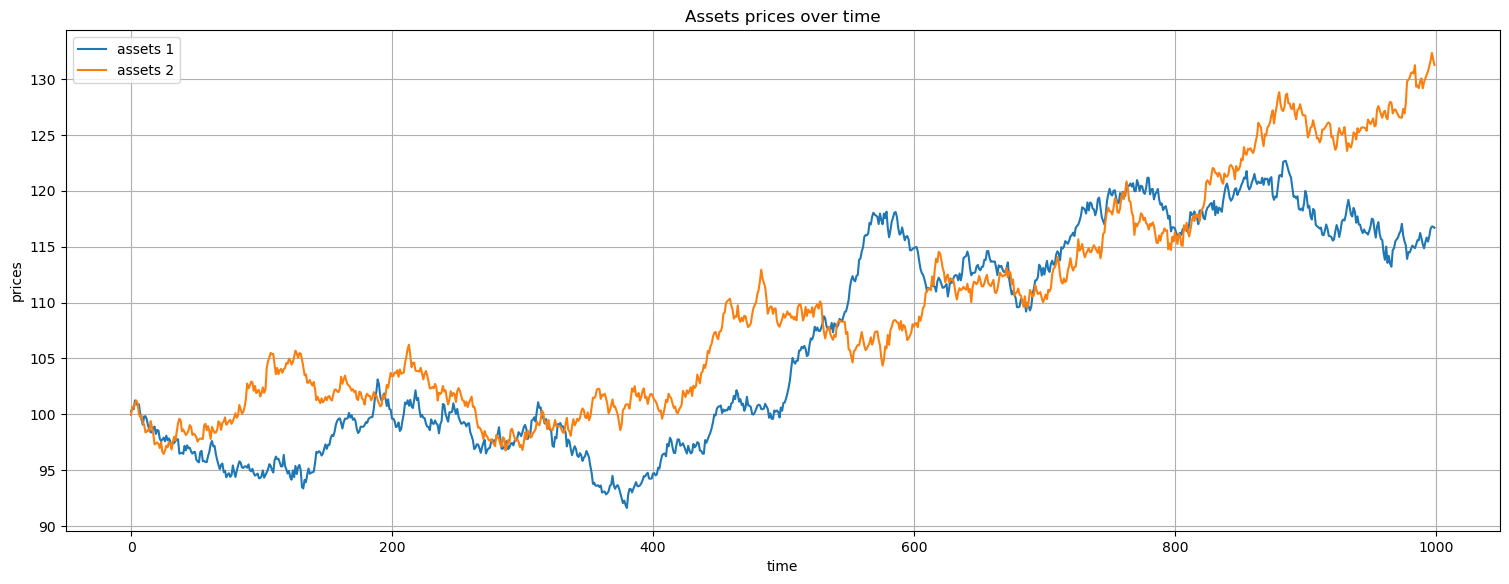

In [3]:
# Plot the assets curves in the same plot
def plot_assets_curves(assets_1_prices, assets_2_prices):
    """plot the assets curves in the same plot"""

    # first create a figure
    fig, ax = plt.subplots()

    # Set size of the figure
    fig.set_size_inches(18.5, 6.5)

    # plot the assets curves
    ax.plot(assets_1_prices, label="assets 1")
    ax.plot(assets_2_prices, label="assets 2")

    # add a legend
    ax.legend()

    # add a title
    ax.set_title("Assets prices over time")

    # add labels to the axes
    ax.set_xlabel("time")
    ax.set_ylabel("prices")

    # add grid
    ax.grid(True)

    # show the plot
    plt.show()


plot_assets_curves(asset1, asset2)

## 2.2. Fix the z-scores computation

The error: when extracting mean and std, whe are using information from future. We need to use information only from past.

In [4]:
# Compute z-scores for each asset
z1 = (asset1 - asset1.rolling(30).mean()) / asset1.rolling(30).std()
z2 = (asset2 - asset2.rolling(30).mean()) / asset2.rolling(30).std()

## 2.3. Continue

In [5]:
# Compute the spread between the two assets
z_spread = z1 - z2

# Compute the rolling mean and standard deviation of the spread
spread_mean = z_spread.rolling(30).mean()
spread_std = z_spread.rolling(30).std()

# Compute the upper and lower bounds fot the spread
upper_bound = spread_mean + spread_std * 2
lower_bound = spread_mean - spread_std * 2

# Compute long and short signals
long_signals = (z_spread <= lower_bound).astype(int)
short_signals = (z_spread >= upper_bound).astype(int)

# Compute signals for asset1 and asset2
asset1_signals = long_signals - short_signals
asset2_signals = -asset1_signals

# Compute positions for each asset. Position is the latest non-zero signal seen for each asset
# For example:
# asset1_signals = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1, 0]
# so, asset1_position = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1]
asset1_position = asset1_signals.replace(to_replace=0, method="ffill")
asset2_position = asset2_signals.replace(to_replace=0, method="ffill")


asset1_orders = asset1_position.diff().fillna(0).clip(-1, 1).astype(int)


# create a three columns print with the signals and positions for asset1
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(pd.concat([asset1_signals, asset1_position, asset1_orders], axis=1))

## 2.4. Let's plot buy and sell orders

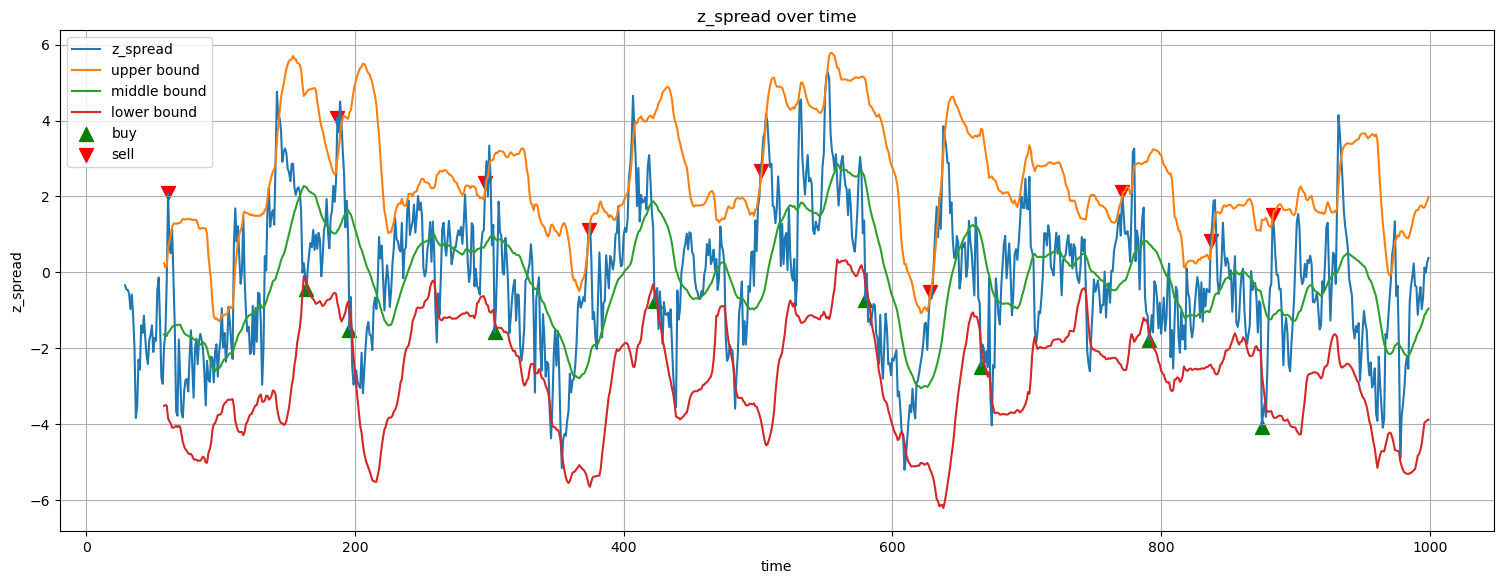

In [6]:
def calculate_bollinger_bands(z_spread, window_size, num_of_std):
    """calculate the upper, middle and lower bollinger bands for the z_spread"""

    # Compute the rolling mean and standard deviation of the spread
    spread_mean = z_spread.rolling(window_size).mean()
    spread_std = z_spread.rolling(window_size).std()

    # Compute the upper and lower bounds for the spread
    upper_bound = spread_mean + spread_std * num_of_std
    lower_bound = spread_mean - spread_std * num_of_std

    # The middle band is the spread mean
    middle_band = spread_mean

    return upper_bound, middle_band, lower_bound


# Plot the z_spread along with the buy and sell orders
def plot_z_spread(z_spread, orders):
    """plot the z_spread along with the buy and sell orders"""

    # first create a figure
    fig, ax = plt.subplots()

    # Set size of the figure
    fig.set_size_inches(18.5, 6.5)

    # plot the z_spread
    ax.plot(z_spread, label="z_spread")

    # plot the upper and lower bands
    upper_bound, middle_band, lower_bound = calculate_bollinger_bands(z_spread, 30, 2)
    ax.plot(upper_bound, label="upper bound")
    ax.plot(middle_band, label="middle bound")
    ax.plot(lower_bound, label="lower bound")

    # Get the buy orders x
    buy_orders = orders > 0
    buy_x = buy_orders[buy_orders[0] == True].index.tolist()

    # plot buy orders
    ax.scatter(
        buy_x, z_spread.iloc[buy_x], marker="^", color="green", label="buy", s=100
    )

    # Get the sell orders x
    sell_orders = orders < 0
    sell_x = sell_orders[sell_orders[0] == True].index.tolist()

    # plot sell orders
    ax.scatter(
        sell_x, z_spread.iloc[sell_x], marker="v", color="red", label="sell", s=100
    )

    # add a legend
    ax.legend()

    # add a title
    ax.set_title("z_spread over time")

    # add labels to the axes
    ax.set_xlabel("time")
    ax.set_ylabel("z_spread")

    # add grid
    ax.grid(True)

    # show the plot
    plt.show()


plot_z_spread(z_spread, asset1_orders)

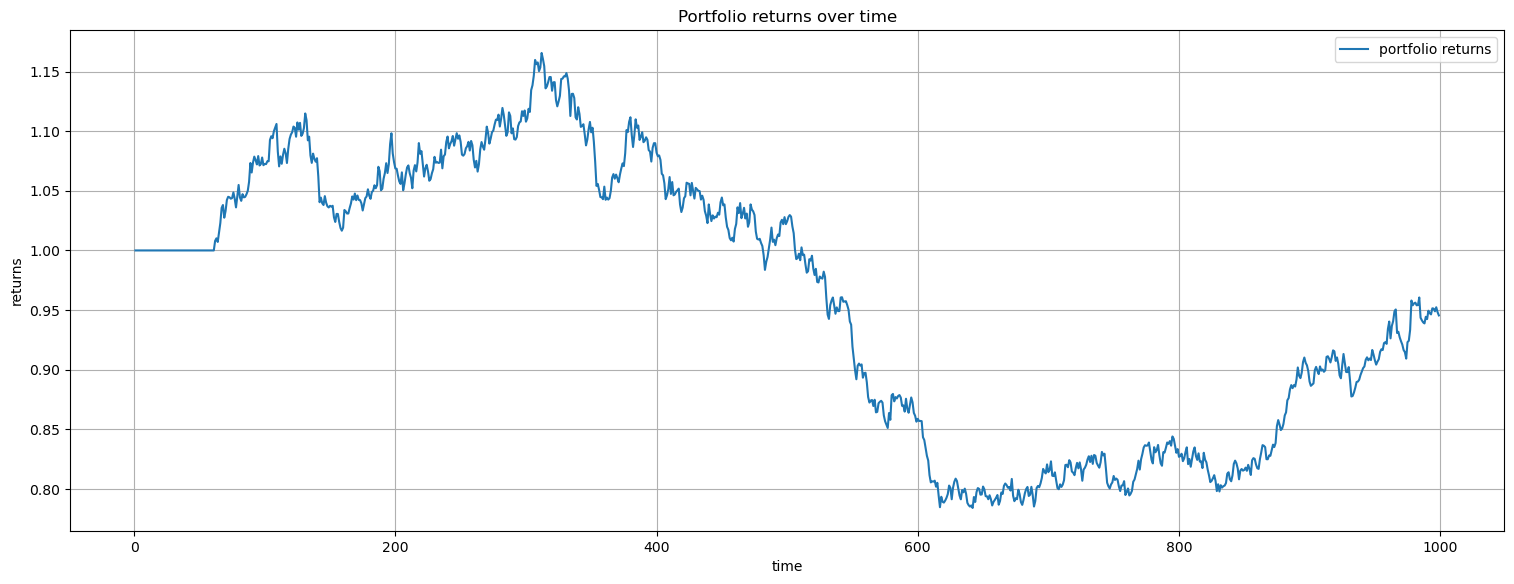

In [8]:
# Compute portfolio returns
portfolio_returns = (
    asset1_position.shift(1) * asset1.pct_change()
    + asset2_position.shift(1) * asset2.pct_change()
)

# Compute the cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()


# plot the portfolio returns
def plot_portfolio_returns(portfolio_returns):
    """plot the portfolio returns"""

    # first create a figure
    fig, ax = plt.subplots()

    # Set size of the figure
    fig.set_size_inches(18.5, 6.5)

    # plot the portfolio returns
    ax.plot(portfolio_returns, label="portfolio returns")

    # add a legend
    ax.legend()

    # add a title
    ax.set_title("Portfolio returns over time")

    # add labels to the axes
    ax.set_xlabel("time")
    ax.set_ylabel("returns")

    # add grid
    ax.grid(True)

    # show the plot
    plt.show()


plot_portfolio_returns(cumulative_returns)